<a href="https://colab.research.google.com/github/zhangxs131/Tensorflow_learning/blob/main/MPG_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Basic Regression

本文是使用tensorflow完成回归任务的example，使用数据集为auto MPG,一个描述70年代汽车烟油效率的模型，特征包括了，气缸数，排量，马力，重量等

In [1]:
!pip install -q seaborn

In [6]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [7]:
#读取数据

#下载数据集
dataset_path=keras.utils.get_file('auto-mpg.data',"http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

40960/30286 [========================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [17]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


###数据清洗

In [18]:
dataset.isna().sum()
dataset = dataset.dropna()
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [19]:
#拆分数据集
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

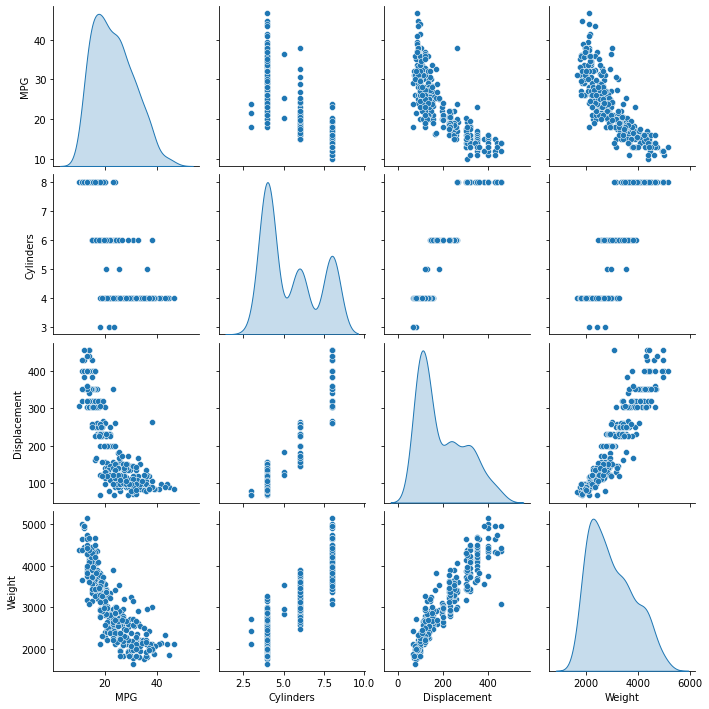

In [20]:
#查看联合分布
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']],diag_kind='kde')

In [21]:
#查看统计数据
train_stats=train_dataset.describe()
train_stats.pop('MPG')
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [ ]:
#分离label与特征
train_labels=train_dataset.pop('MPG')
test_labels=test_dataset.pop('MPG')

#特征进行归一化处理
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']
norm_train_data=norm(train_dataset)
norm_test_data=norm(test_dataset)
#查看数据

##构建模型并训练

这里直接使用几个MLP层，输入shape，为特征数，最后进行回归分类即可

In [25]:
model=keras.Sequential([
  keras.layers.Dense(64,activation='relu',input_shape=[len(train_dataset.keys())]),
  keras.layers.Dense(16,activation='relu'),
  keras.layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer=keras.optimizers.RMSprop(0.001),
  metrics=['mae','mse']
)

history=model.fit(
  norm_train_data,
  train_labels,
  epochs=500,
  validation_split=0.2,
  verbose=1,
)

Epoch 1/500
8/8 [==============================] - 1s 34ms/step - loss: 574.3158 - mae: 22.7187 - mse: 574.3158 - val_loss: 574.9968 - val_mae: 22.7334 - val_mse: 574.9968
Epoch 2/500
8/8 [==============================] - 0s 5ms/step - loss: 536.3389 - mae: 21.9119 - mse: 536.3389 - val_loss: 539.0318 - val_mae: 21.9729 - val_mse: 539.0318
Epoch 3/500
8/8 [==============================] - 0s 5ms/step - loss: 503.2860 - mae: 21.1961 - mse: 503.2860 - val_loss: 503.9348 - val_mae: 21.2103 - val_mse: 503.9348
Epoch 4/500
8/8 [==============================] - 0s 5ms/step - loss: 470.1397 - mae: 20.4538 - mse: 470.1397 - val_loss: 466.6648 - val_mae: 20.3664 - val_mse: 466.6648
Epoch 5/500
8/8 [==============================] - 0s 5ms/step - loss: 435.1350 - mae: 19.6293 - mse: 435.1350 - val_loss: 427.4548 - val_mae: 19.4302 - val_mse: 427.4548
Epoch 6/500
8/8 [==============================] - 0s 5ms/step - loss: 398.1746 - mae: 18.7173 - mse: 398.1746 - val_loss: 386.2332 - val_mae: 1

In [26]:
#训练结果可视化
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,4.718602,1.444810,4.718602,7.989131,2.125557,7.989131,495
496,4.489321,1.449294,4.489321,8.728427,2.276666,8.728427,496
497,4.886634,1.483772,4.886634,8.043421,2.109652,8.043421,497
498,4.639879,1.441858,4.639879,8.044681,2.104545,8.044681,498
499,4.640152,1.447882,4.640152,8.246155,2.187361,8.246155,499


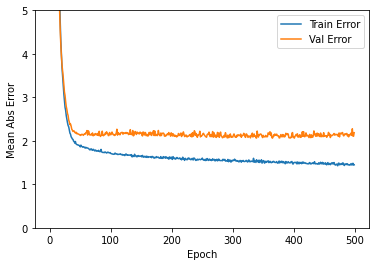

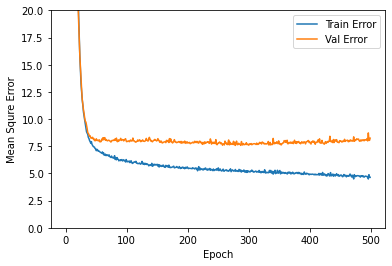

In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'],hist['mae'],label='Train Error')
  plt.plot(hist['epoch'],hist['val_mae'],label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squre Error')
  plt.plot(hist['epoch'],hist['mse'],label='Train Error')
  plt.plot(hist['epoch'],hist['val_mse'],label='Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.show()

plot_history(history)

##使用early stop进行停止训练

Epoch 1/500
8/8 [==============================] - 1s 27ms/step - loss: 570.4040 - mae: 22.5870 - mse: 570.4040 - val_loss: 578.9020 - val_mae: 22.7154 - val_mse: 578.9020
Epoch 2/500
8/8 [==============================] - 0s 6ms/step - loss: 540.7824 - mae: 21.9222 - mse: 540.7824 - val_loss: 549.3049 - val_mae: 22.0501 - val_mse: 549.3049
Epoch 3/500
8/8 [==============================] - 0s 5ms/step - loss: 512.9268 - mae: 21.2774 - mse: 512.9268 - val_loss: 518.5651 - val_mae: 21.3439 - val_mse: 518.5651
Epoch 4/500
8/8 [==============================] - 0s 5ms/step - loss: 483.9968 - mae: 20.5907 - mse: 483.9968 - val_loss: 486.0595 - val_mae: 20.5724 - val_mse: 486.0595
Epoch 5/500
8/8 [==============================] - 0s 5ms/step - loss: 453.5721 - mae: 19.8401 - mse: 453.5721 - val_loss: 452.4725 - val_mae: 19.7366 - val_mse: 452.4725
Epoch 6/500
8/8 [==============================] - 0s 5ms/step - loss: 421.2741 - mae: 19.0134 - mse: 421.2741 - val_loss: 416.4213 - val_mae: 1

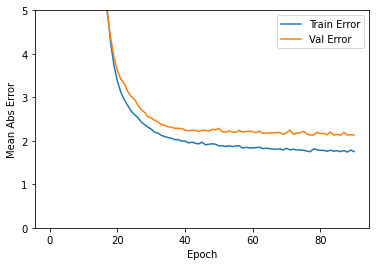

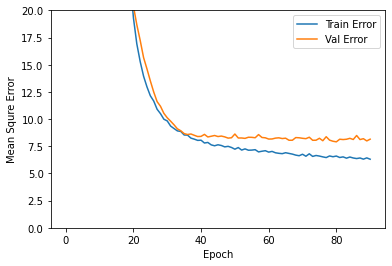

In [31]:
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

#创建新模型训练
model=keras.Sequential([
  keras.layers.Dense(64,activation='relu',input_shape=[len(train_dataset.keys())]),
  keras.layers.Dense(16,activation='relu'),
  keras.layers.Dense(1)
])

model.compile(
  loss='mse',
  optimizer=keras.optimizers.RMSprop(0.001),
  metrics=['mae','mse']
)
history = model.fit(norm_train_data, train_labels, epochs=500,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop])

plot_history(history)

##验证

In [32]:
loss,mae,mse=model.evaluate(norm_test_data,test_labels,verbose=2)

print('MAE:',mae)

3/3 - 0s - loss: 5.6804 - mae: 1.8608 - mse: 5.6804 - 34ms/epoch - 11ms/step
MAE: 1.8607909679412842


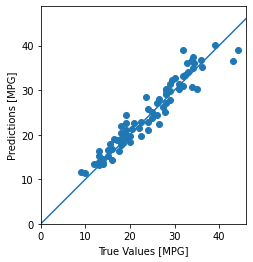

In [33]:
#predict
test_predictions = model.predict(norm_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

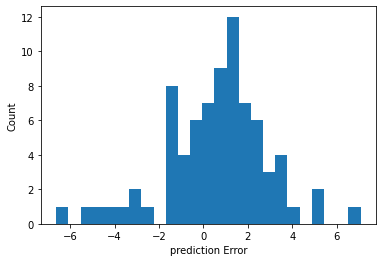

In [34]:
#误差分布
error=test_predictions-test_labels
plt.hist(error,bins=25)
plt.xlabel('prediction Error')
_=plt.ylabel('Count')